In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras

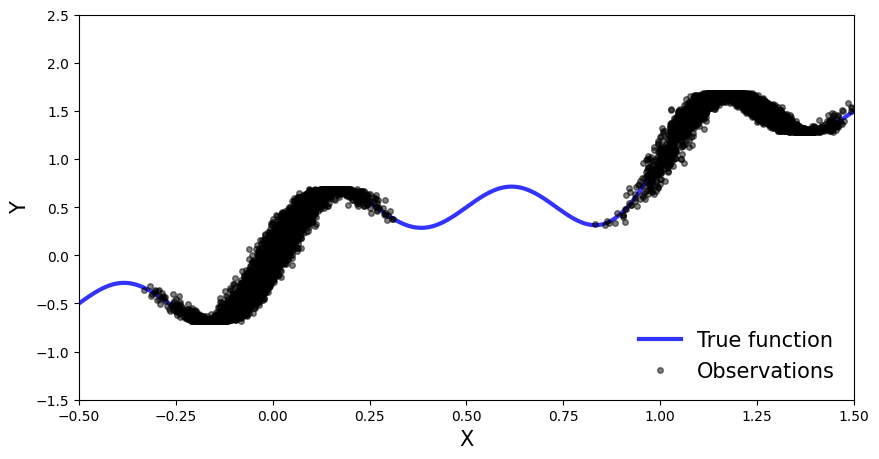

In [184]:
np.random.seed(42+1)

X_train = np.hstack([0.1 * np.random.randn(5000), 0.6 + 0.2 * np.random.randn(0), 1.2 + 0.1 * np.random.randn(5000)])
noise = 0.02 * np.random.randn(X_train.shape[0])
y_train = X_train + 0.3 * np.sin(2 * np.pi * (X_train + noise)) + 0.3 * np.sin(4 * np.pi * (X_train + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function", alpha=0.8)
ax.plot(X_train, y_train, 'ko', markersize=4, label="Observations", alpha=0.5)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

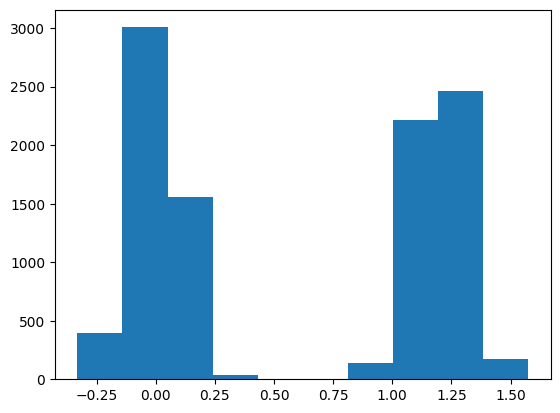

In [185]:
plt.hist(X_train)
plt.show()

In [210]:
event_shape = [1]
params_size = tfp.layers.MixtureNormal.params_size(1, event_shape)

model = tf_keras.Sequential([
    tf_keras.layers.Dense(128, activation='relu', input_shape=(1,)),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(params_size),
    tfp.layers.MixtureNormal(1, event_shape)
])

def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001), loss=negloglik)
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_169 (Dense)           (None, 128)               256       
                                                                 
 dense_170 (Dense)           (None, 128)               16512     
                                                                 
 dense_171 (Dense)           (None, 128)               16512     
                                                                 
 dense_172 (Dense)           (None, 3)                 387       
                                                                 
 mixture_normal_46 (Mixture  ((None, 1),               0         
 Normal)                      (None, 1))                         
                                                                 
Total params: 33667 (131.51 KB)
Trainable params: 33667 (131.51 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [211]:
history = model.fit(X_train,y_train, epochs=100, verbose=1)

Epoch 1/100
313/313 [==============================] - 0s 364us/step - loss: -0.2197
Epoch 2/100
313/313 [==============================] - 0s 322us/step - loss: -0.4835
Epoch 3/100
313/313 [==============================] - 0s 287us/step - loss: -0.5375
Epoch 4/100
313/313 [==============================] - 0s 267us/step - loss: -0.6342
Epoch 5/100
313/313 [==============================] - 0s 300us/step - loss: -0.6871
Epoch 6/100
313/313 [==============================] - 0s 295us/step - loss: -0.7491
Epoch 7/100
313/313 [==============================] - 0s 286us/step - loss: -0.7884
Epoch 8/100
313/313 [==============================] - 0s 296us/step - loss: -0.8620
Epoch 9/100
313/313 [==============================] - 0s 282us/step - loss: -0.9442
Epoch 10/100
313/313 [==============================] - 0s 301us/step - loss: -1.0148
Epoch 11/100
313/313 [==============================] - 0s 287us/step - loss: -1.0776
Epoch 12/100
313/313 [==============================] - 0s 300u

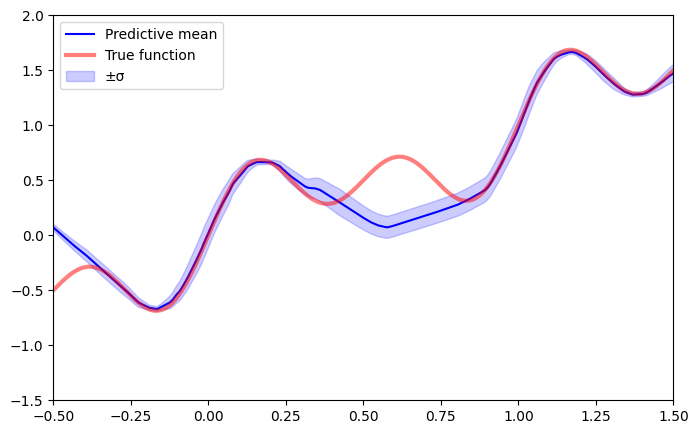

In [212]:
x_test = np.linspace(-1, 2, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)
y_dist = model(x_test)
y_pred = y_dist.mean().numpy()
y_std = y_dist.stddev().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
# plt.plot(X_train, y_train, 'kx', label='Train data')
plt.plot(x_test, y_pred, 'b', label='Predictive mean')
plt.plot(x_test, y_test, 'r', linewidth=3, label="True function", alpha=0.5)
plt.fill_between(x_test.flatten(),
                 (y_pred - y_std).reshape(-1),
                 (y_pred + y_std).reshape(-1),
                 color='blue', alpha=0.2, label='±σ')
plt.ylim(-1.5,2)
plt.xlim(-0.5, 1.5)
plt.legend()
plt.show()

In [134]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf_keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf_keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [202]:
tfd = tfp.distributions
tfpl = tfp.layers

scale = X_train.shape[0] / 1.1


event_shape = [1]
params_size = tfp.layers.MixtureNormal.params_size(1, event_shape)

norm_layer = tf_keras.layers.Normalization(input_shape=(1,))
norm_layer.adapt(X_train.reshape(-1,1))

model = tf_keras.Sequential([
    norm_layer,
    tfpl.DenseFlipout(128, activation='relu',
                      kernel_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale,
                      bias_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale),
    tfpl.DenseFlipout(128, activation='relu',
                      kernel_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale,
                      bias_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale),
    tfpl.DenseFlipout(128, activation='relu',
                      kernel_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale,
                      bias_divergence_fn=lambda q,p,ignore: tfp.distributions.kl_divergence(q, p) / scale),
    tf_keras.layers.Dense(params_size),
    tfp.layers.MixtureNormal(1, event_shape)
])

def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

lr_schedule = tf_keras.optimizers.schedules.ExponentialDecay(0.001, 16*1000, 0.99,staircase=False)

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001), loss=negloglik)
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_36 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_flipout_85 (DenseFli  (None, 128)               384       
 pout)                                                           
                                                                 
 dense_flipout_86 (DenseFli  (None, 128)               32896     
 pout)                                                           
                                                                 
 dense_flipout_87 (DenseFli  (None, 128)               32896     
 pout)                                                           
                                                                 
 dense_168 (Dense)           (None, 3)               

In [203]:
x_test = np.linspace(-0.5, 1.5, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)


loss_log_dir = "../logs/fit/loss/BNN"
history = model.fit(X_train,y_train, validation_data=(x_test, y_test), epochs=1000, verbose=1, batch_size=128,
                    callbacks=[tf_keras.callbacks.TensorBoard(log_dir=loss_log_dir, histogram_freq=1), tf_keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                                                        mode='min',
                                                                                                                                        patience=30,
                                                                                                                                        verbose=1,
                                                                                                                                        start_from_epoch=1,
                                                                                                                                        restore_best_weights=True)])

Epoch 1/1000
79/79 [==============================] - 1s 4ms/step - loss: 9.3582 - val_loss: 12.7245
Epoch 2/1000
79/79 [==============================] - 0s 1ms/step - loss: 8.6719 - val_loss: 11.3434
Epoch 3/1000
79/79 [==============================] - 0s 1ms/step - loss: 8.3959 - val_loss: 11.3601
Epoch 4/1000
79/79 [==============================] - 0s 1ms/step - loss: 8.1493 - val_loss: 9.8339
Epoch 5/1000
79/79 [==============================] - 0s 1ms/step - loss: 7.9240 - val_loss: 10.1330
Epoch 6/1000
79/79 [==============================] - 0s 1ms/step - loss: 7.6921 - val_loss: 9.7559
Epoch 7/1000
79/79 [==============================] - 0s 1ms/step - loss: 7.5040 - val_loss: 9.6195
Epoch 8/1000
79/79 [==============================] - 0s 1ms/step - loss: 7.2662 - val_loss: 9.0198
Epoch 9/1000
79/79 [==============================] - 0s 1ms/step - loss: 7.0515 - val_loss: 8.8677
Epoch 10/1000
79/79 [==============================] - 0s 1ms/step - loss: 6.8355 - val_loss: 9.

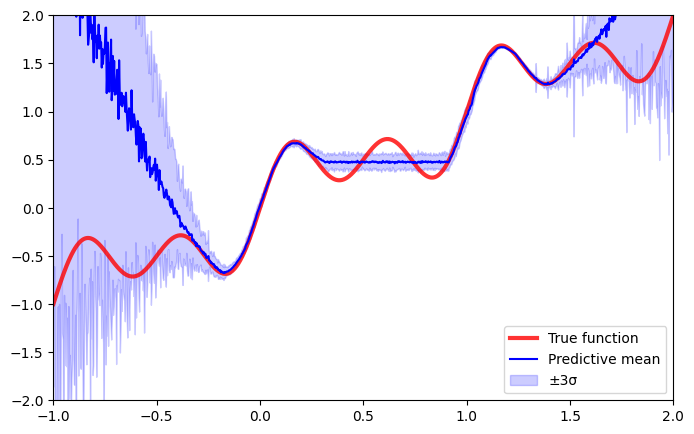

In [205]:
x_test = np.linspace(-1, 2, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)

means = []
stds = []
for _ in range(30):
    dist = model(x_test)
    means.append(dist.mean().numpy())
    stds.append(dist.stddev().numpy())

y_mean = np.array(means).mean(axis=0)
y_std = 0 #np.sqrt(np.sum(np.array(stds) ** 2 / 10, axis=0))
y_mean_std = np.array(means).std(axis=0)
y_std = np.sqrt(y_std ** 2 + y_mean_std ** 2)


import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
# plt.plot(X_train, y_train, 'kx', label='Train data')
plt.plot(x_test, y_test, 'r', linewidth=3, label="True function", alpha=0.8)
plt.plot(x_test, y_mean, color='b', label='Predictive mean')
plt.fill_between(x_test.flatten(),
                 (y_mean - 3 * y_std).reshape(-1),
                 (y_mean + 3 * y_std).reshape(-1),
                 color='blue', alpha=0.2, label='±3σ')
plt.ylim(-2,2)
plt.xlim(-1, 2)
plt.legend()
plt.show()

In [21]:
## ---- REDSHIFT DATA ----

In [49]:
import importlib

import data_frame
import models

In [54]:
importlib.reload(data_frame)
importlib.reload(models)

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())

config = {}
model = models.MLModelContext(strategy=models.BayesianNN(df, config))

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_vari

In [55]:
model.train()

Epoch 1/1000
889/889 [==============================] - 14s 14ms/step - loss: 5.3047 - val_loss: 4.6631
Epoch 2/1000
889/889 [==============================] - 12s 13ms/step - loss: 4.1949 - val_loss: 3.9822
Epoch 3/1000
889/889 [==============================] - 12s 13ms/step - loss: 3.8113 - val_loss: 3.6532
Epoch 4/1000
889/889 [==============================] - 12s 13ms/step - loss: 3.6430 - val_loss: 3.5140
Epoch 5/1000
889/889 [==============================] - 12s 13ms/step - loss: 3.5493 - val_loss: 3.4678
Epoch 6/1000
889/889 [==============================] - 12s 13ms/step - loss: 3.4882 - val_loss: 3.3972
Epoch 7/1000
889/889 [==============================] - 12s 13ms/step - loss: 3.4389 - val_loss: 3.3576
Epoch 8/1000
889/889 [==============================] - 12s 13ms/step - loss: 3.3857 - val_loss: 3.3717
Epoch 9/1000
889/889 [==============================] - 12s 13ms/step - loss: 3.3451 - val_loss: 3.2877
Epoch 10/1000
889/889 [==============================] - 12s 13m

KeyboardInterrupt: 